<a href="https://colab.research.google.com/github/erc-kluijtmans/Machine-Learning/blob/master/Simple_Transformer_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources
https://github.com/huggingface/blog/blob/main/notebooks/02_how_to_generate.ipynb





https://www.youtube.com/watch?v=-QH8fRhqFHM&ab_channel=JayAlammar


In [10]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 62.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.9 MB/s eta 0:00:00


In [11]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2',pad_token_id=tokenizer.eos_token_id)


Using larget datset and machine learning does not give computers the ability to understand language. All these LMs are trained to predict owrds (or charcaters or sentences). Deep learning models can only process numeric values: they can’t take raw text as input. Vectorizing text is the process of transforming text into numericals. Text vectorization processes come in many shapes and forms, but they all follow the same template:

*   First, you standardize the text to make it easier to process, such as by 
converting it to lowercase or removing punctuation.
*   You split the text into units (called **tokens**), such as characters, words, or groups of words. This is called tokenization.
*   You convert each such token into a numerical vector. This will usually involve first indexing all tokens present in the data. A numerical vector is also called **embedding**. An embedding is defined as a representation of a word and encodes the meaning of the word in such a way that words that are closer in the vector space are expected to be similar in meaning.

Example of Tokenization - Fig.1
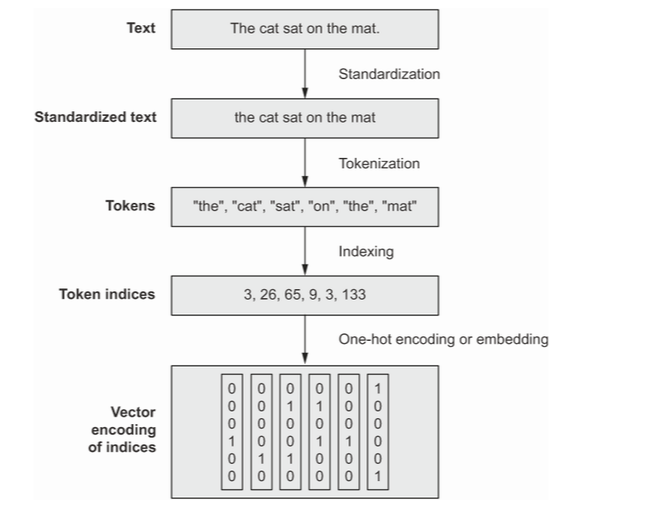


In [12]:
text = "the car was"

# Tokenize the input string
input = tokenizer.encode(text, return_tensors="pt")

# Run the model
output = model.generate(input, max_length=20, do_sample=False)

# Print the output
print('\n',tokenizer.decode(output[0]))


 the car was parked in the driveway of the house.

The driver of the car was not


In [15]:
model. transformer.wte

Embedding(50257, 768)

The model we use contains 50257 tokens and each token is coded with an embedding of 768 dimensions.

In [17]:
word_embeddings

Parameter containing:
tensor([[-0.1101, -0.0393,  0.0331,  ..., -0.1364,  0.0151,  0.0453],
        [ 0.0403, -0.0486,  0.0462,  ...,  0.0861,  0.0025,  0.0432],
        [-0.1275,  0.0479,  0.1841,  ...,  0.0899, -0.1297, -0.0879],
        ...,
        [-0.0445, -0.0548,  0.0123,  ...,  0.1044,  0.0978, -0.0695],
        [ 0.1860,  0.0167,  0.0461,  ..., -0.0963,  0.0785, -0.0225],
        [ 0.0514, -0.0277,  0.0499,  ...,  0.0070,  0.1552,  0.1207]],
       requires_grad=True)

In [18]:
# Print the token ides (of the input and output)
output

tensor([[1169, 3797, 3332,  319,  262, 2603,   11,  290,  262, 3797, 3332,  319,
          262, 2603,   11,  290,  262, 3797, 3332,  319,  262, 2603,   11,  290,
          262, 3797, 3332,  319,  262, 2603,   11,  290,  262, 3797, 3332,  319,
          262, 2603,   11,  290,  262, 3797, 3332,  319,  262, 2603,   11,  290,
          262, 3797]])

## From words to vectors and back

In [14]:
# Print the input token ids
text = "car"
input = tokenizer(text, return_tensors="pt")['input_ids']
input

tensor([[7718]])

In [15]:
tokenizer.convert_ids_to_tokens(input[0])

['car']

## Breathe meaning into numbers (Embedding)

In [13]:
# This is the embedding matrix of the model
model.transformer.wte # Dimensions are: (Number of tokens in vocabulary, dimension of model)

Embedding(50257, 768)

In [21]:
import torch

In [22]:
# Get the embedding vector of token # 464 ('The')
model.transformer.wte(torch.tensor(464))

tensor([-6.8623e-02, -2.0298e-02,  6.4471e-02, -6.2085e-02, -1.1352e-01,
        -6.2337e-02, -2.1719e-01, -2.9746e-02,  3.8659e-03, -1.0428e-02,
        -3.7695e-02,  2.6119e-02,  7.6351e-02, -3.0347e-02,  1.0757e-01,
        -1.8893e-02,  5.6020e-02,  5.1582e-02, -2.4212e-02,  1.3702e-01,
        -4.6440e-02,  2.9035e-02, -5.2729e-02,  3.9311e-02, -5.7571e-03,
        -3.4328e-02,  5.1317e-02, -2.7329e-02, -6.9629e-02,  1.7323e-02,
        -3.6435e-02, -5.7844e-02, -5.8048e-02,  6.3479e-02, -4.3887e-02,
        -3.6068e-02, -3.1934e-01,  7.1641e-02,  8.3253e-02, -2.7106e-02,
         1.1349e-01, -8.6667e-02, -8.2599e-02, -6.6505e-02,  5.5040e-02,
        -5.3986e-03,  1.3219e-02,  2.9831e-02,  6.5156e-02, -1.6650e-01,
        -7.9967e-03,  3.0170e-02,  2.6669e-02,  7.5700e-02,  6.9849e-02,
        -3.6223e-01, -4.4599e-02, -3.8639e-03, -1.1880e-02, -4.6784e-03,
        -4.1325e-02, -3.8791e-02,  3.1904e-02, -2.1479e-02, -2.5077e-01,
         1.7805e-02,  3.9195e-04, -3.6580e-02,  3.1

In [ ]:
text = "What is 3 + 3?"
# Tokenize the input string
input = tokenizer.encode(text, return_tensors="pt")


# activate beam search and early_stopping
beam_output = model.generate(
    input,  
    max_length=100, 
    num_beams=5, 
    no_repeat_ngram_size=2,
    early_stopping=True
)

# Run the model
print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
What is 3 + 3?

3 + 2 = 3.5 + 1.25 + 0.75 = 2.2 + 4.6 = 5.4 + 6.3 = 7.1 + 8.7 = 9.8 + 10.0 = 11.9 + 12.10 = 13.11 + 14.12 = 15.13 + 16.14 = 17.15 + 18.16 = 19.17 + 20.18 = 21.19 +


In [14]:
import torch

input_ids = tokenizer.encode("the cat sleeps on the bed", return_tensors='pt')

# Generate the logits for the input text
with torch.no_grad():
    logits, _ = model(input_ids)

# Access the logits for the last token of the input text
last_token_logits = logits[0][-1]

# Display the logits
print(last_token_logits)

l


In [34]:
import torch

# Encode the input text
input_ids = torch.tensor(tokenizer.encode("oh my")).unsqueeze(0)  # Batch size 1

# Get the logits of the last token
with torch.no_grad():
    outputs = model(input_ids)
    logits = outputs[0][0, -1, :]

# Get the predicted token
predicted_index = torch.argmax(logits).item()
predicted_token = tokenizer.decode([predicted_index])

# Get the probability of all logits
probabilities = torch.softmax(logits, dim=0)

# Print the logits of the last token
print("Logits of the Last Token:", logits)

# Print the probability of all logits
print("Probabilities of All Logits:", probabilities)

# Print the predicted token
print("Predicted Token:", predicted_token)

# Get the probability of the predicted token
predicted_probability = probabilities[predicted_index].item()

# Print the probability of the predicted token
print("Probability of the Predicted Token:", predicted_probability)

Logits of the Last Token: tensor([-73.8390, -74.1809, -79.3946,  ..., -80.1564, -81.5872, -78.0243])
Probabilities of All Logits: tensor([2.1758e-03, 1.5456e-03, 8.4112e-06,  ..., 3.9264e-06, 9.3887e-07,
        3.3110e-05])
Predicted Token:  God
Probability of the Predicted Token: 0.045782435685396194
